In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating new project at `~/Downloads/notebooks/dynamics_tutorial/plain_samples/cart_pendulum`
  No Changes to `~/Downloads/notebooks/dynamics_tutorial/plain_samples/cart_pendulum/Project.toml`
  No Changes to `~/Downloads/notebooks/dynamics_tutorial/plain_samples/cart_pendulum/Manifest.toml`


In [19]:
using DifferentialEquations, ModelingToolkit , LinearAlgebra
# using GLMakie
using ControlSystemsBase, RobustAndOptimalControl, ForwardDiff
using Plots
# plot = Plots.plot

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


In [13]:
function pendulum_plot(sol::ODESolution)
    fig = Figure(resolution=(800, 400))

    position_ax = Axis(fig[1, 1], title="Position")
    angle_ax = Axis(fig[2, 1], title="Angle")

    lines!(angle_ax, sol.t, sol[sys.θ])
#     lines!(position_ax, sol.t, ones(length(sol.t)) * π)
    lines!(position_ax, sol.t, sol[sys.x])

    position_ax.ylabel = "position [rad]"
    angle_ax.ylabel = "angle [rad/s]"
    angle_ax.xlabel = "time [s]"

    rowgap!(fig.layout, 5)

    display(fig)
end

pendulum_plot (generic function with 1 method)

### Dynamics

In [65]:
function CartPendulum(; name)
    # define parameters and variables
    @parameters mc, mp, Jp, l, c, γ
    @variables t Y(t)[1:4,1]=0 U(t)[1,1]=0 [input=true] 
    @variables x(t) θ(t) ẋ(t) θ̇(t)
    @constants g = 9.81  
    
    
    # define operators
    D = Differential(t)

    # equations of motion
    M = [mc+mp -mp*l*cos(θ)
        -mp*l*cos(θ) Jp+(mp*l^2)];
    C = [(c * D(x) + mp * l * sin(θ) * D(θ)^2) - U[1]
        γ * D(θ) - mp * g * l * sin(θ)];
    X_dot = inv(M) * -C;


    # dynamics equations
    eqs = [
        D(D(x)) ~ X_dot[1]
        D(D(θ)) ~ X_dot[2]
        θ̇ ~ D(θ)
        ẋ ~ D(x)
        Y .~ [x, θ, ẋ, θ̇]
    ]

    # create ODESystem and simplify
    @named sys= ODESystem(eqs, t; name)
    
    return sys
end

CartPendulum (generic function with 1 method)

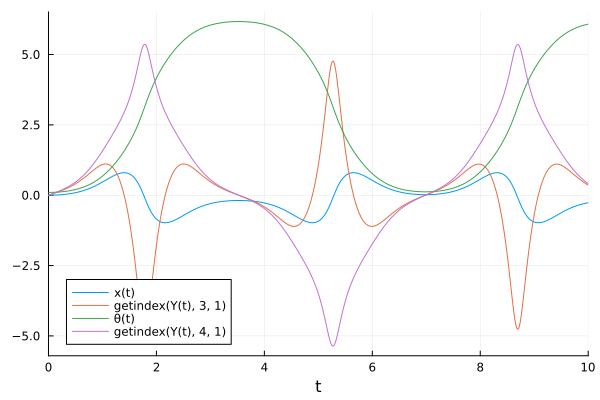

In [67]:
@named sys_unsimplified = CartPendulum()
sys = structural_simplify(sys_unsimplified)

# initial conditions
@nonamespace u₀ = [
    sys.θ => 0.1,
    sys.θ̇ => 0.0,
    sys.x => 0.0,
    sys.ẋ => 0.0,
    sys.U => 0.0]

# parameter values
@nonamespace params = [sys.mc => 10,
    sys.mp => 80,
    sys.Jp => 100,
    sys.l => 1,
    sys.c => 0.1,
    sys.γ => 0.01]

#Pass to solver
tspan = (0.0, 10.0)
prob = ODEProblem(sys, u₀, tspan, params , jac=true)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

# pendulum_plot(sol)
Plots.plot(sol)

### Linearization

In [87]:
function convert_to_numeric(A::Array{Num})
    A_num = [convert(Float64, i.val) for i in A]
    
    return A_num
end


@parameters mc, mp, Jp, l, g, c, γ
@variables t x(t) θ(t) (M(t))[1:2, 1:2] (C(t))[2] (X_dot(t))[2] U(t)[1,1]=0 [input=true]

# define operators
D = Differential(t)

params = Dict(mc => 10,
    mp => 80,
    Jp => 100,
    l => 1,
    g => 9.81,
    c => 0.1,
    γ => 0.01)

# initial conditions
u₀ = Dict(D(θ) => 0.0,
    θ => 0.0,
    D(x) => 0.0,
    x => 0.0,
    U => 0.0)

# vector of nonlinear eqns of motion
nonlinear_eq_vec = [D(x), D(θ), equations(sys_unsimplified)[1].rhs, equations(sys_unsimplified)[2].rhs]
state_vec = [x, θ, D(x), D(θ)]
control_vec = [U[1,1]]

# Calculate A,B matrices
Ac = Symbolics.jacobian(nonlinear_eq_vec, state_vec)
Ac = substitute(Ac, u₀)
Ac = substitute(Ac, params)

Bc = Symbolics.jacobian(nonlinear_eq_vec, control_vec)
Bc = substitute(Bc, u₀)
Bc = substitute(Bc, params)

Cc = [1 1 0 0]

# Create state space system 
sys_c = ss(convert_to_numeric(Ac), convert_to_numeric(Bc), Cc, 0)


StateSpace{Continuous, Float64}
A = 
 0.0  0.0                 1.0                     0.0
 0.0  0.0                 0.0                     1.0
 0.0  6.406530612244898  -0.0018367346938775511  -8.163265306122449e-5
 0.0  7.207346938775511  -0.0008163265306122449  -9.183673469387756e-5
B = 
 0.0
 0.0
 0.018367346938775512
 0.00816326530612245
C = 
 1.0  1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

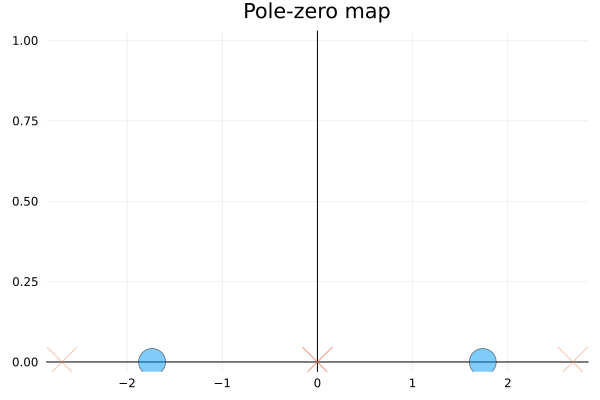

In [88]:
isstable(sys_c)
pzmap(sys_c)

### PID controller using MTK

In [434]:
function pid_ctrl(;kp,ki,kd, name)
    @variables t u(t)=0 e_accum(t)=0 y(t)=0 [input=true] r(t)=0 [input=true] e(t)=0
    @parameters kp=kp ki=ki kd=kd
    
     # define operators
    D = Differential(t)

    eqs = [
        e ~ r - y,       # error
        D(e_accum) ~ e , # accumulated error 
        u ~ kp*e + ki*e_accum+ kd*D(e)
    ]
    
    ODESystem(eqs, t; name = name)
end


function step(;height, name)
    @variables y(t) [output = true] 
    @parameters height=height
    eqs = [
        y ~ height
    ]
    ODESystem(eqs, t; name = name)
end

step (generic function with 1 method)

### LQR Controller

In [435]:
# Design controller
Q       = Diagonal([10,1,1,5]) # Weighting matrix for state
R       = I # Weighting matrix for input

# Compute LQR gain matrix
K      = lqr(convert_to_numeric(Ac),convert_to_numeric(Bc),Q,R) # lqr(sys,Q,R) can also be used

1×4 Matrix{Float64}:
 -3.16228  1952.02  -26.3731  749.4

In [436]:
# @variables t X(t)[1:4,1]=0 U(t)[1,1]=0.0 

# K = [−15.6, 1730, −50.1, 443]
# K = reshape(K, (1,4))

# k_f = −15.6
# ref = 1
# val = -K*X

# U = -K*X .+ k_f*ref

In [437]:
function LQRController(Ac, Bc, Q, R; name)
    @variables t X(t)[1:4,1]=0 [input=true] U(t)[1,1]=0.0 
#     @parameters Ac=Ac
    
     # define operators
    D = Differential(t)

    # Compute LQR gain matrix
    K = lqr(convert_to_numeric(Ac),convert_to_numeric(Bc),Q,R) # lqr(sys,Q,R) can also be used
    K = [−15.6, 1730, −50.1, 443]
    K = reshape(K, (1,4))
    
    k_f = −15.6
    ref = 1

    val = -K*X
    
    eqs = [
        U[1] .~ val[1] .+ k_f*ref
#         U ~ val .+ k_f*ref
    ]
    
    ODESystem(eqs, t; name)
end


function StateEstimator(; name)
    @variables t  X(t)[1:4]=0 [input=true] η(t)=0.0 Y(t)[1:4,1]=0
    #     @parameters kp=kp ki=ki kd=kd
    
     # define operators
    D = Differential(t)

    eqs = [
        Y ~ X .+ η  #add noise term
        D(η) ~ 0
    ]
    
    ODESystem(eqs, t; name)
end


StateEstimator (generic function with 1 method)

In [438]:
function SystemModel(plant,estimator, ctrl)
    
    eqs = [
        plant.Y ~ estimator.X
        estimator.Y ~ ctrl.X
        ctrl.U ~ plant.U
    ]

    @named sys = ODESystem(eqs, t, systems = [plant,estimator, ctrl])
end

@named plant = CartPendulum();
@named est = StateEstimator();

# Design controller
Q       = Diagonal([1,10,1,1]) # Weighting matrix for state
R       = I # Weighting matrix for input
@named ctrl = LQRController(Ac, Bc, Q, R);

# create model of whole system
sys = SystemModel(plant, est, ctrl);
sys = structural_simplify(sys);

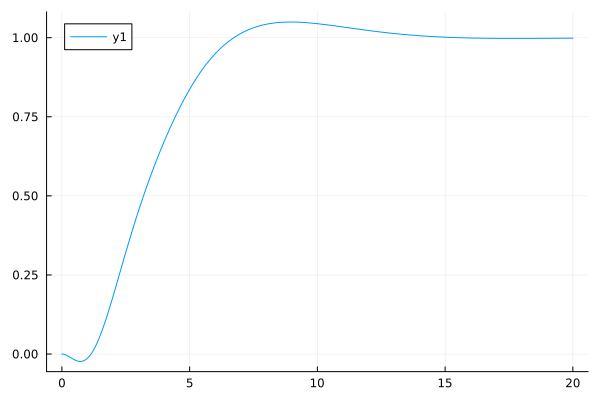

In [439]:
# initial conditions
@nonamespace u₀ = [
    sys.plant₊θ => 0.0,
    sys.plant₊θ̇ => 0.0,
    sys.plant₊x => 0.0,
    sys.plant₊ẋ => 0.0]

# parameter values
@nonamespace params = [
    sys.plant₊mc => 10,
    sys.plant₊mp => 80,
    sys.plant₊Jp => 100,
    sys.plant₊l => 1,
    sys.plant₊c => 0.1,
    sys.plant₊γ => 0.01]

@named plant = CartPendulum();
@named est = StateEstimator();

# Design controller
Q       = Diagonal([1,10,1,10]) # Weighting matrix for state
R       = 1 # Weighting matrix for input
@named ctrl = LQRController(Ac, Bc, Q, R);

# create model of whole system
sys = SystemModel(plant, est, ctrl);
sys = structural_simplify(sys);

#Pass to solver
tspan = (0.0, 20.0)
prob = ODEProblem(sys, u₀, tspan, params , jac=true)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

# pendulum_plot(sol)
Plots.plot(sol.t, sol[sys.plant₊x])